In [1]:
from risk_experiment.utils import Subject, get_all_subjects
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
subjects = get_all_subjects('/data/ds-risk')

In [3]:
from tqdm.notebook import tqdm

In [4]:
pars = []
keys = []

for sub in tqdm(subjects):

    for session in ['3t1', '3t2', '7t1', '7t2']:
        try:
            if session.endswith('2'):
                pars.append(sub.get_prf_parameters_volume(session, None, cross_validated=False, smoothed=True, denoise=True, retroicor=False, roi='npcr', include_r2=True, include_cvr2=True, epi_space=False))
            else:
                pars.append(sub.get_prf_parameters_volume(session, None, cross_validated=False, smoothed=True, denoise=False, retroicor=False, roi='npcr', include_r2=True, include_cvr2=False, epi_space=False))

            keys.append((sub.subject, session))

        except Exception as e:
            print(f'Problem with {sub.subject}/{session}: {e}')

  0%|          | 0/30 [00:00<?, ?it/s]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

In [5]:
pars = pd.concat(pars, keys=keys, names=['subject', 'session'])

In [6]:
pars = pars.unstack('session')

In [7]:
m = (pars[('cvr2', '7t2')] > 0.0) & (pars[('cvr2', '3t2')] > 0.0)

In [8]:
p1 = pars.groupby('subject').apply(lambda d: d['r2'].corr()).stack().to_frame('r')
p2 = pars[m].groupby('subject').apply(lambda d: d['r2'].corr()).stack().to_frame('r')
p3 = pars.groupby('subject').apply(lambda d: d['mu'].corr()).stack().to_frame('r')
p4 = pars[m].groupby('subject').apply(lambda d: d['mu'].corr()).stack().to_frame('r')

r = pd.concat((p1, p2, p3, p4), keys=[('r2', 'all voxels'), ('r2', 'cross-validated R2 > 0.0 for 3t2 and 7t2'), ('mu', 'all voxels'), ('mu', 'cross-validated R2 > 0.0 for 3t2 and 7t2')], names=['parameter', 'type'])

r = r[r.index.get_level_values(-2) != r.index.get_level_values(-1)]

r.index.set_names(['session 1', 'session 2'], [-2, -1], inplace=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_48065/1631213453.py:10: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_names except for the argument 'names' will be keyword-only.
  r.index.set_names(['session 1', 'session 2'], [-2, -1], inplace=True)


In [9]:
sns.set_context('talk')

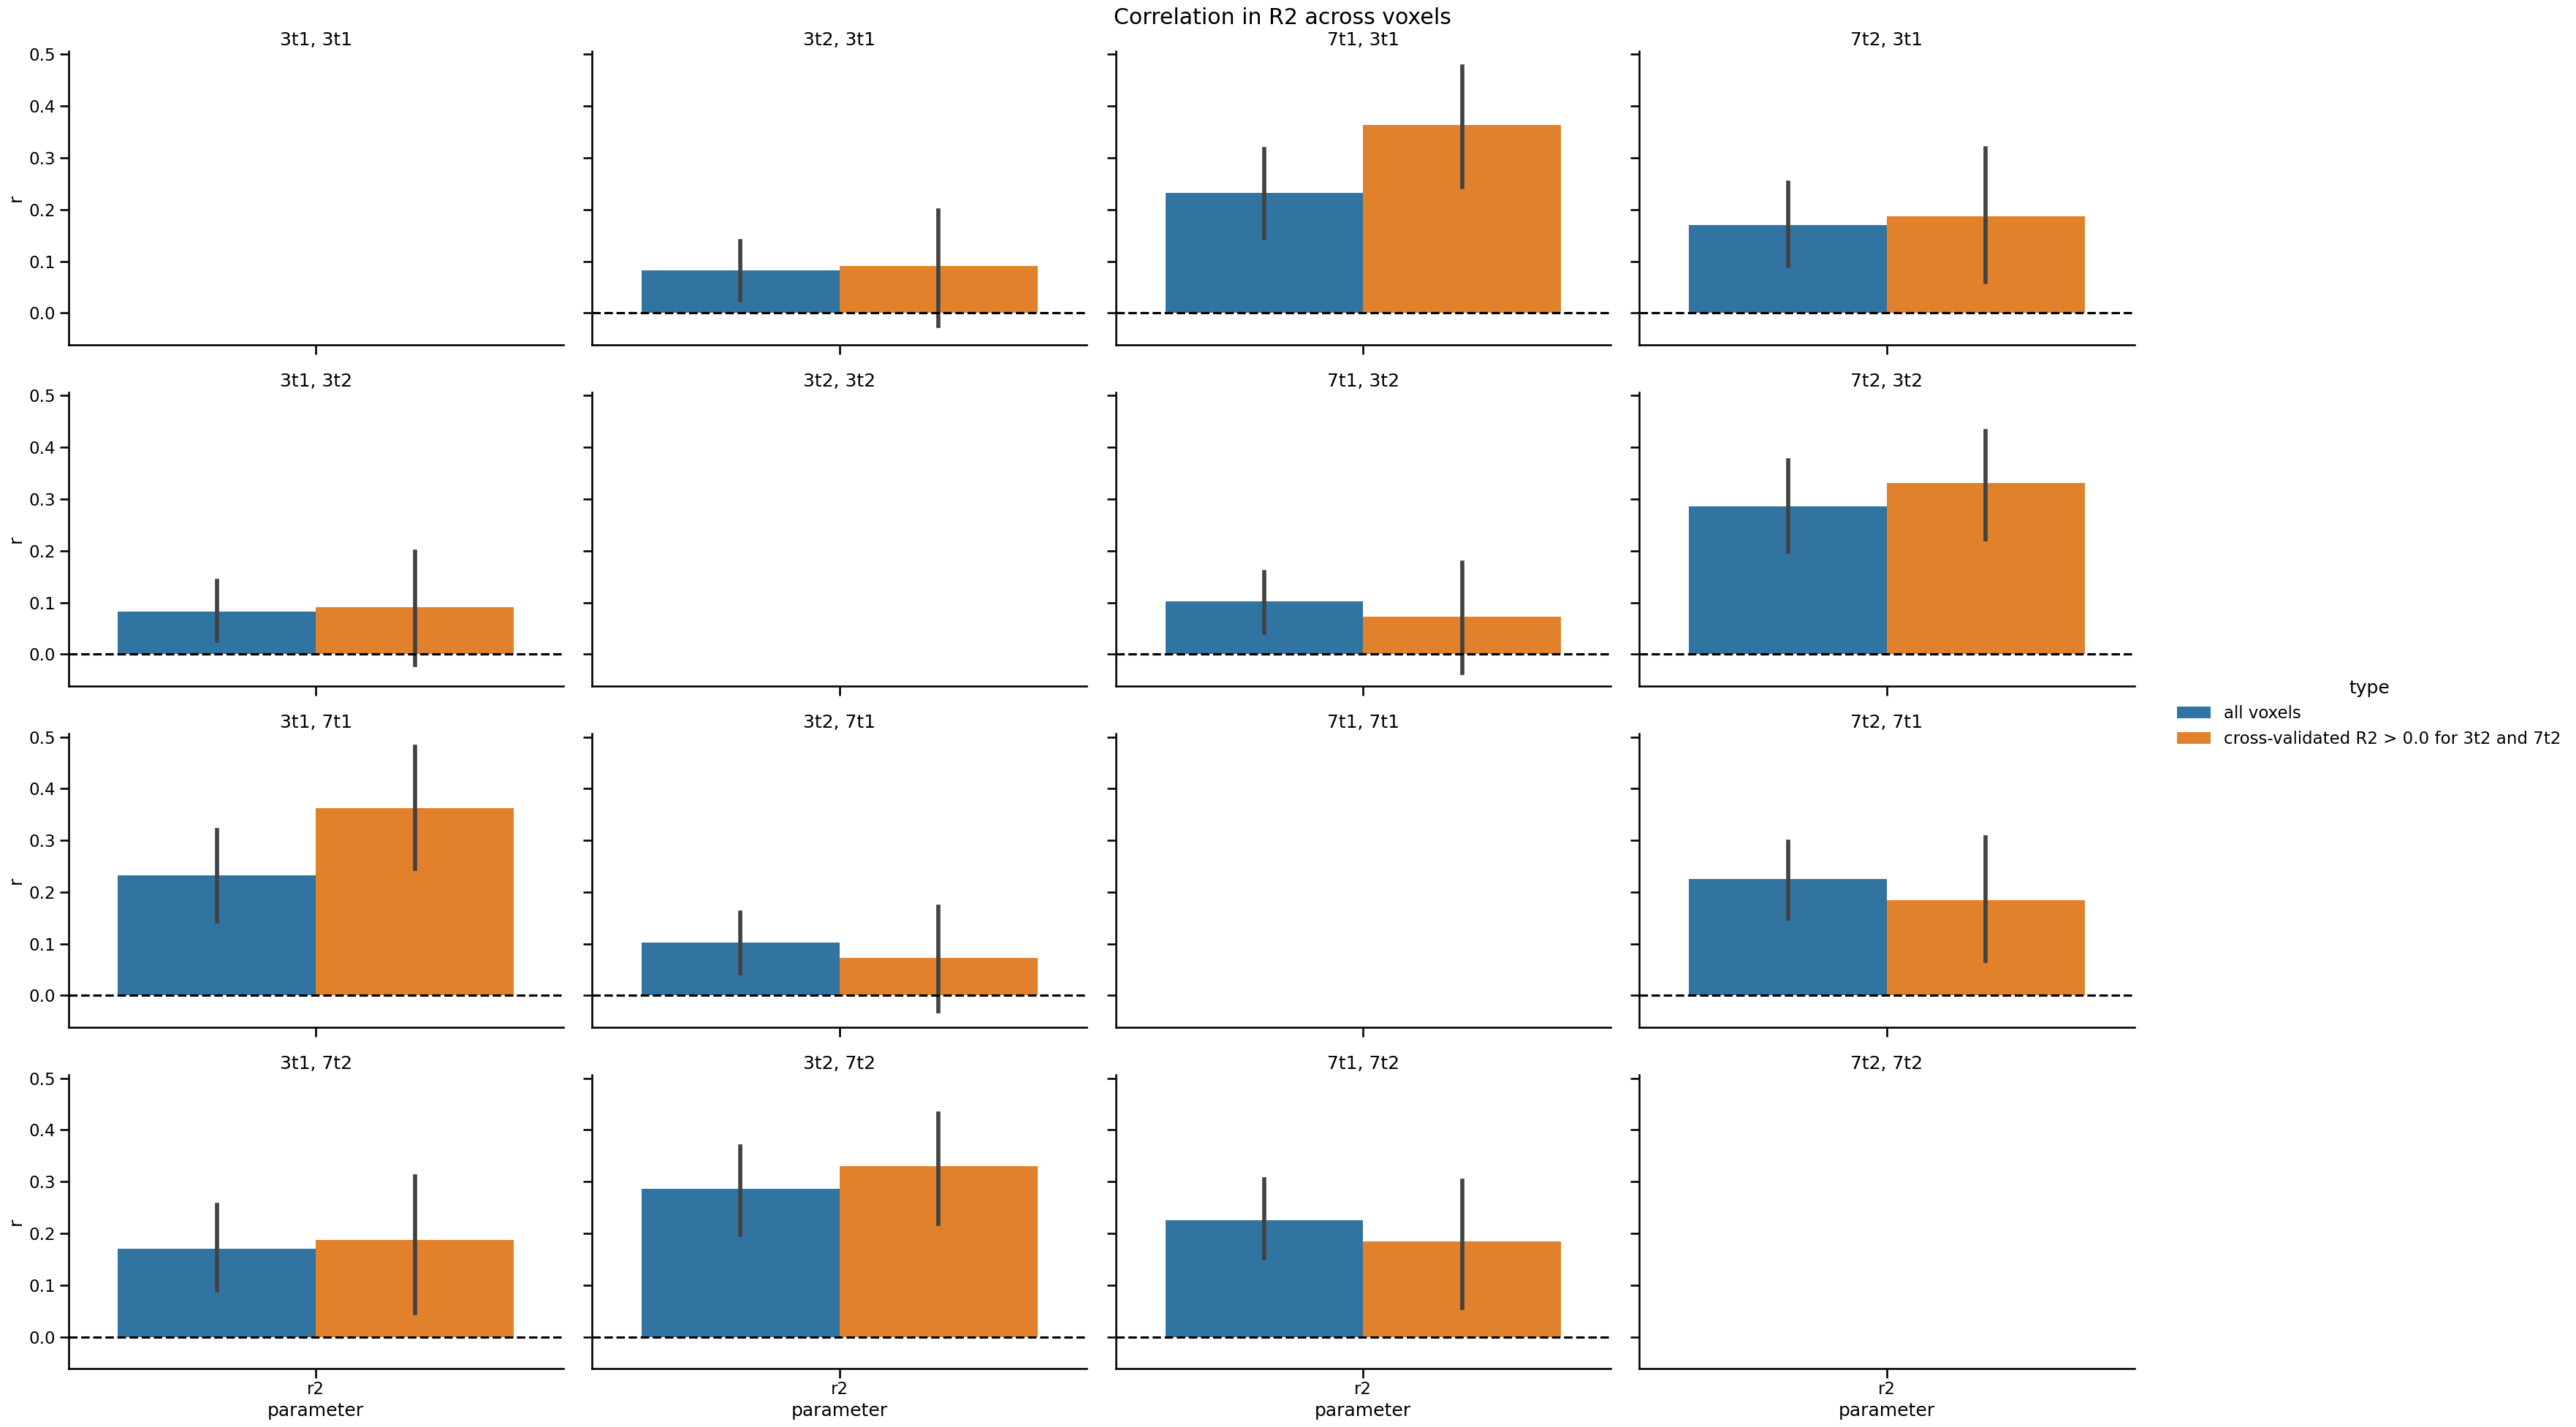

In [10]:
g = sns.catplot(r.xs('r2', 0, 'parameter', drop_level=False).reset_index(), row='session 1', y='r', col='session 2', x='parameter', hue='type', kind='bar', dodge=True, aspect=1.5, errorbar=('ci', 95),
row_order=['3t1', '3t2', '7t1', '7t2'], col_order=['3t1', '3t2', '7t1', '7t2'])
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
g.fig.suptitle('Correlation in R2 across voxels', )
g.set_titles('{col_name}, {row_name}')
plt.subplots_adjust(top=0.95)

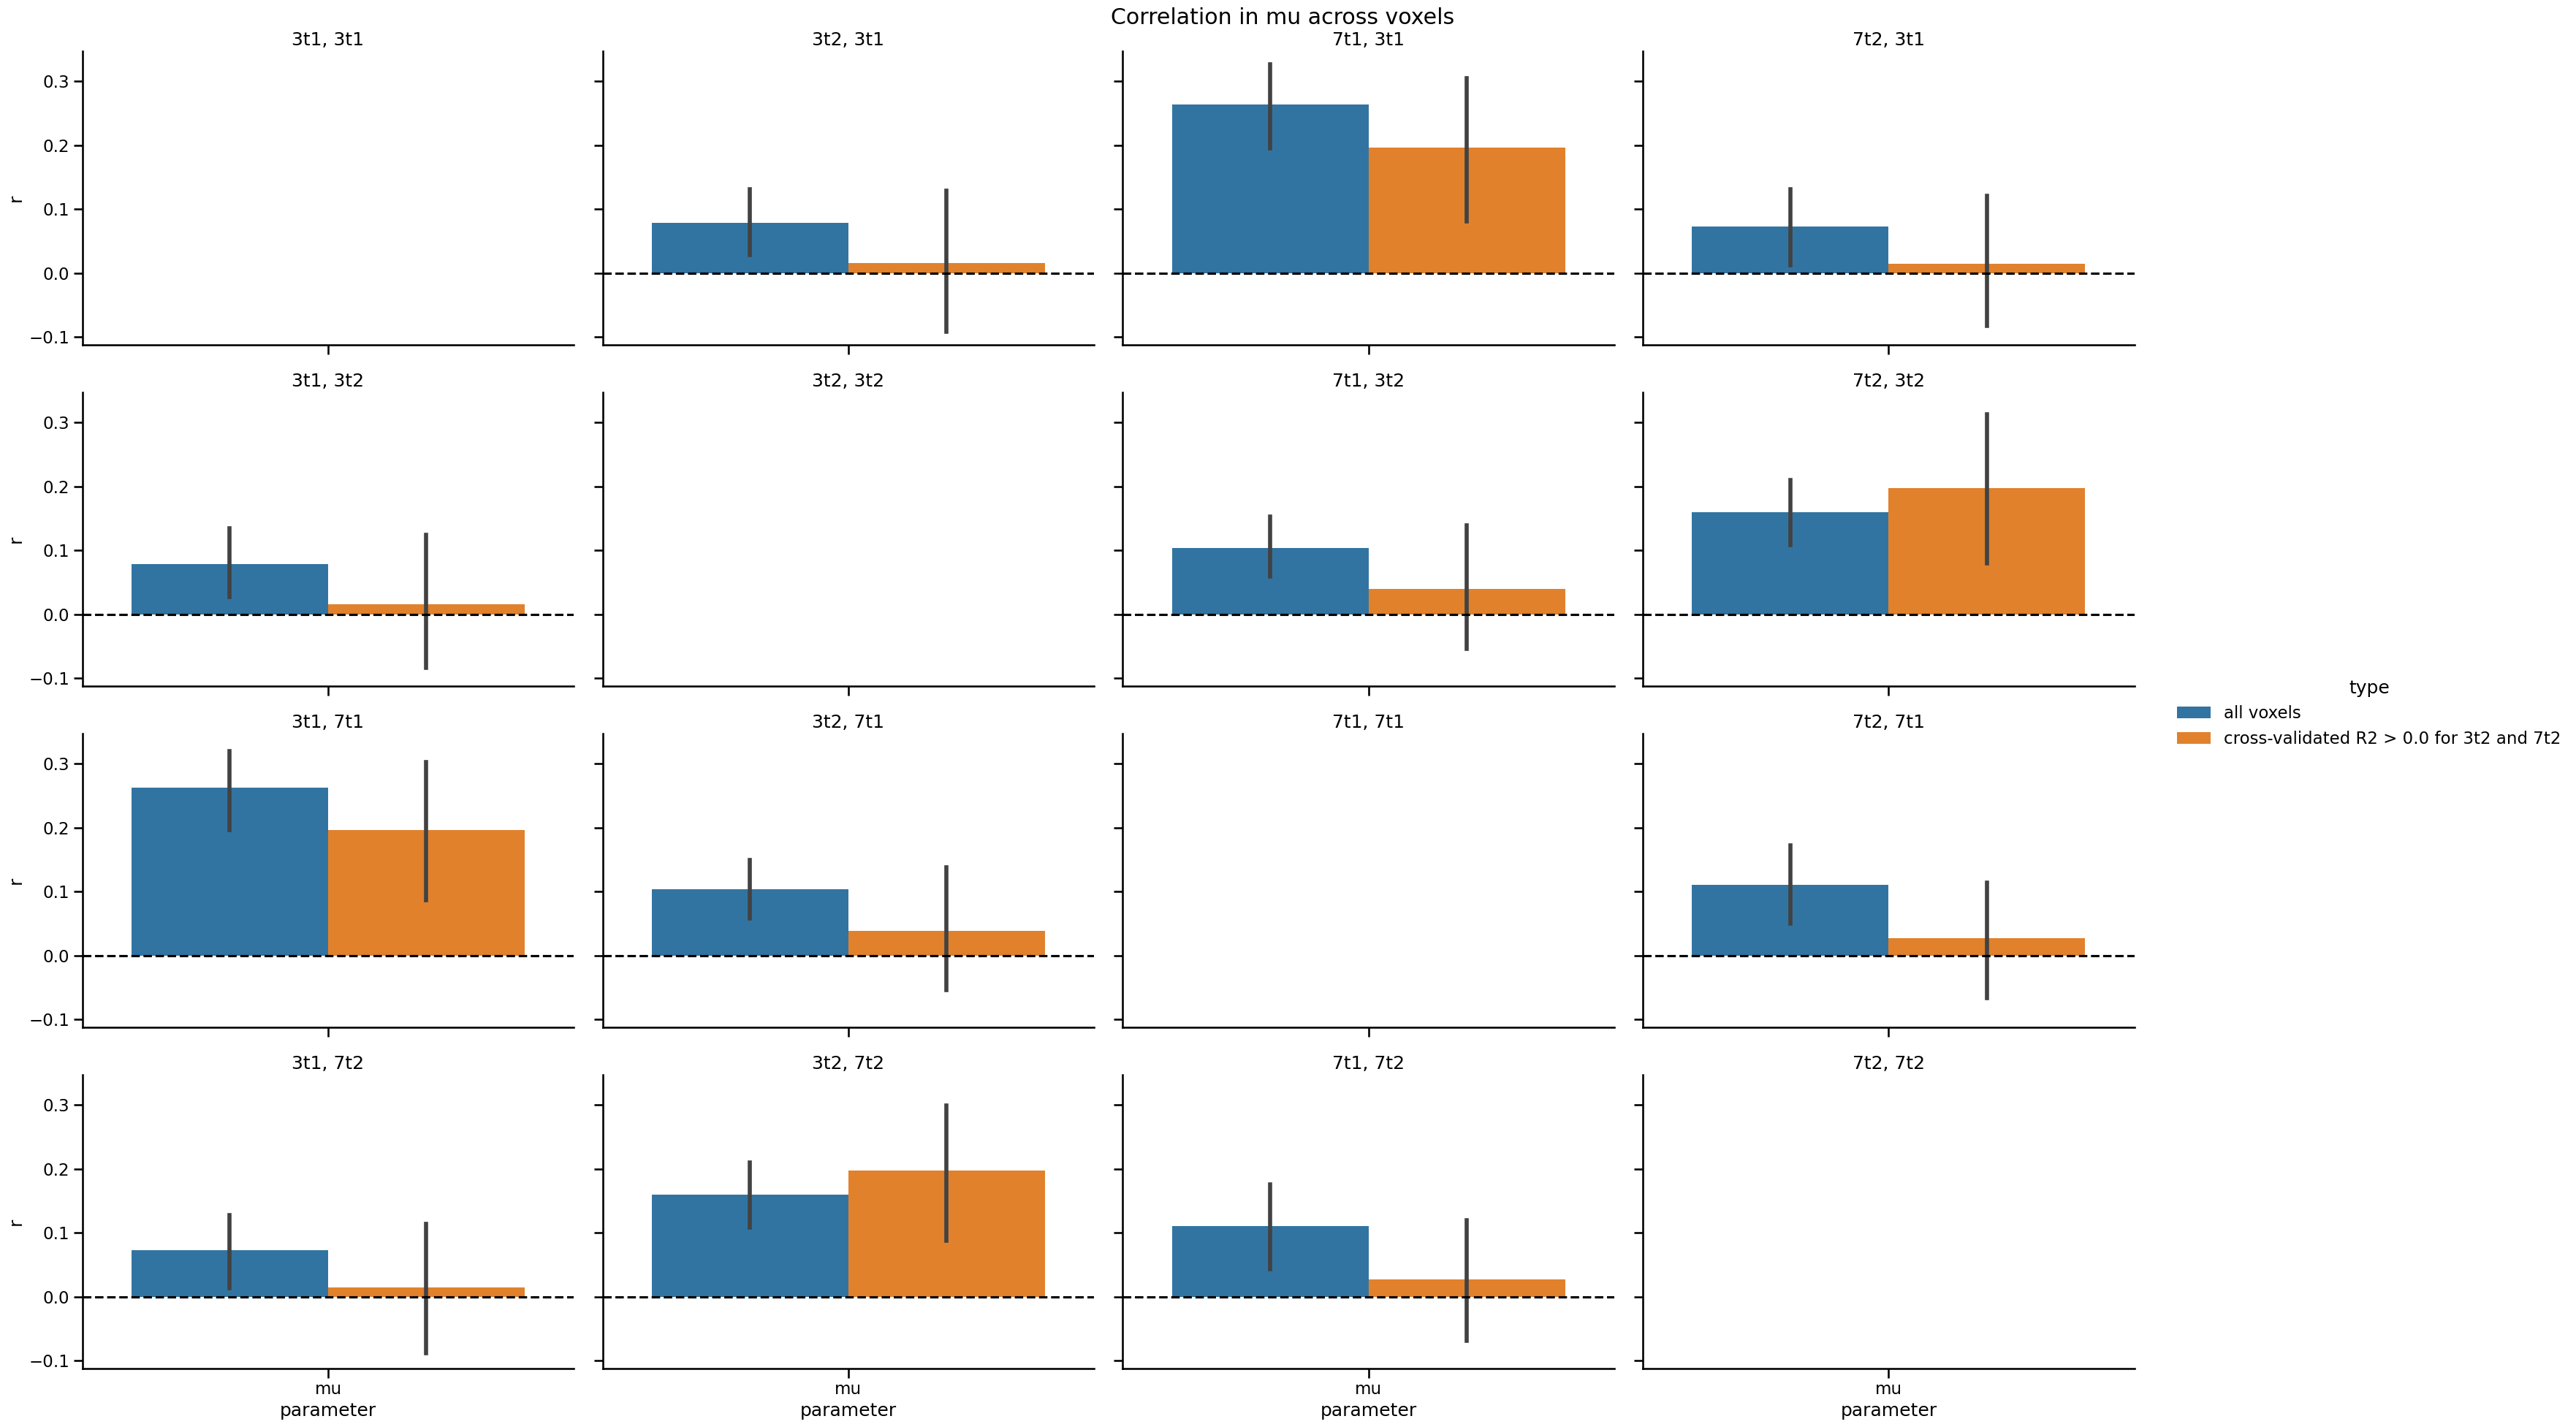

In [11]:
g = sns.catplot(r.xs('mu', 0, 'parameter', drop_level=False).reset_index(), row='session 1', y='r', col='session 2', x='parameter', hue='type', kind='bar', dodge=True, aspect=1.5, errorbar=('ci', 95),
row_order=['3t1', '3t2', '7t1', '7t2'], col_order=['3t1', '3t2', '7t1', '7t2'])
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
g.fig.suptitle('Correlation in mu across voxels', )
g.set_titles('{col_name}, {row_name}')
plt.subplots_adjust(top=0.95)

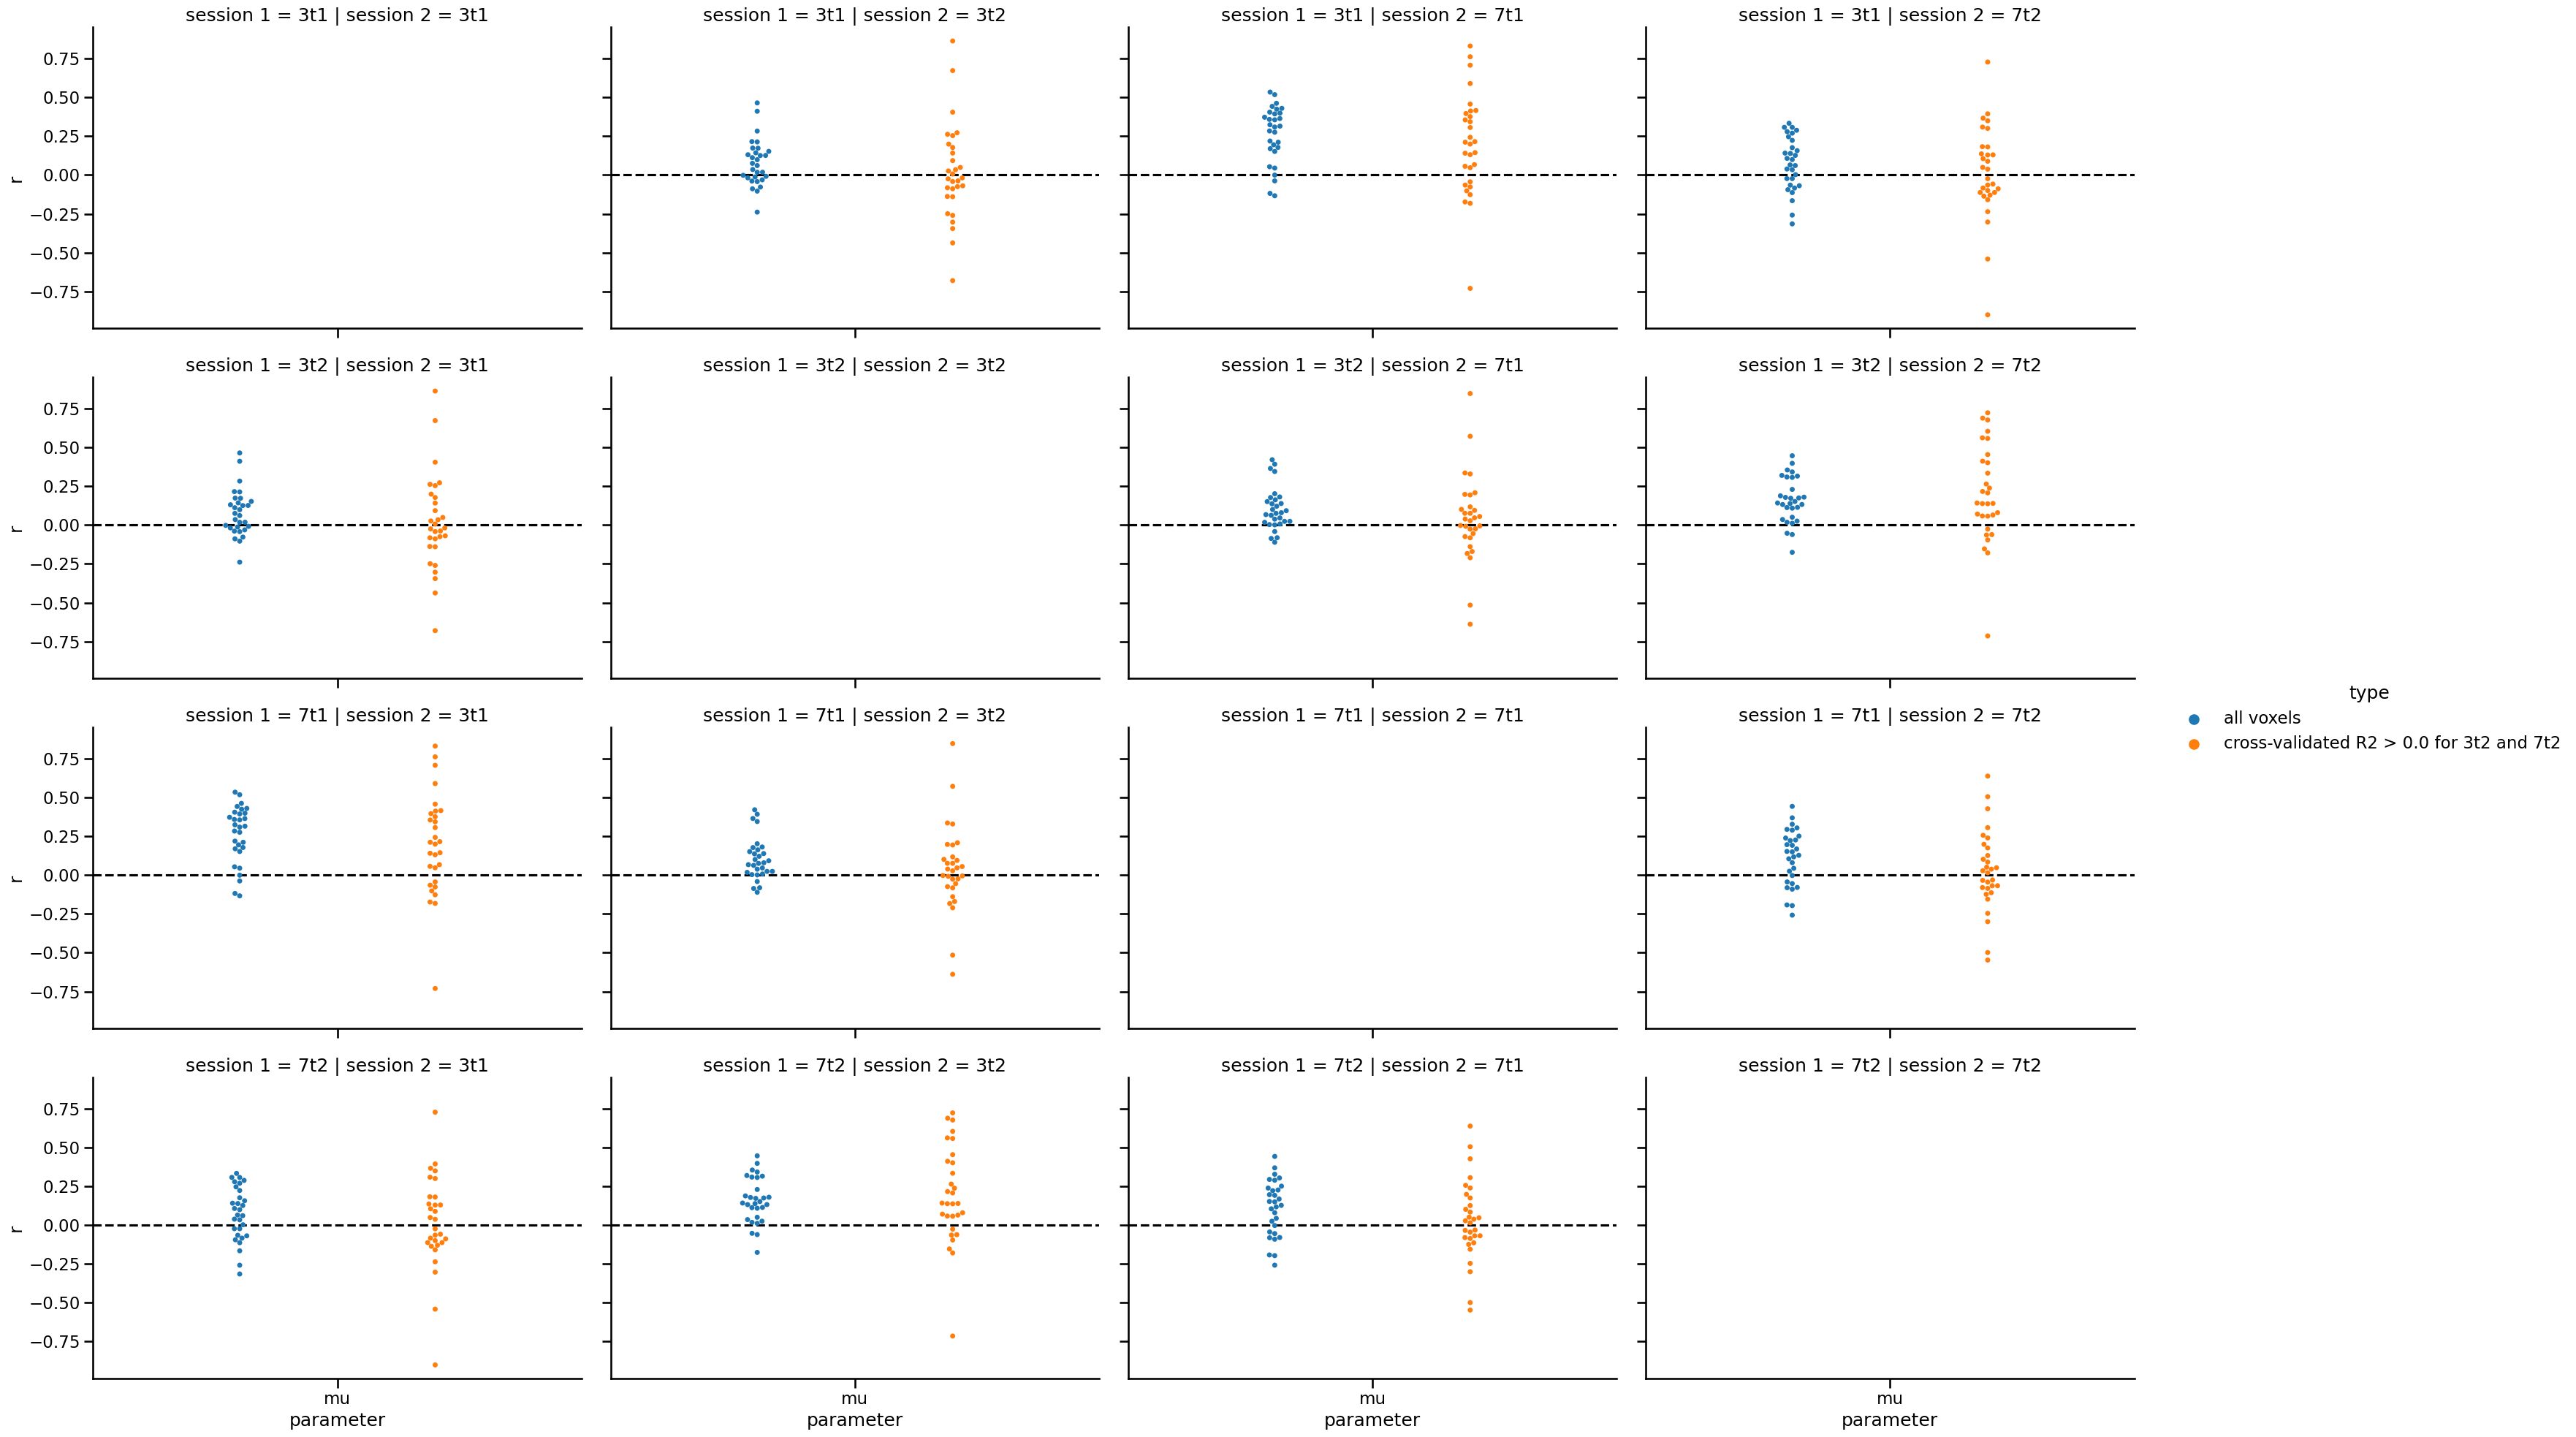

In [12]:
g = sns.catplot(r.xs('mu', 0, 'parameter', drop_level=False).reset_index(), row='session 1', y='r', col='session 2', x='parameter', hue='type', kind='swarm', dodge=True, aspect=1.5, errorbar=('ci', 95),
row_order=['3t1', '3t2', '7t1', '7t2'], col_order=['3t1', '3t2', '7t1', '7t2'])
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

In [13]:
pars[m].groupby('subject').apply(lambda d: d['r2'].corr()).groupby('session').mean()

session,3t1,3t2,7t1,7t2
session,,,,
3t1,1.000000,0.091515,0.363003,0.186696
3t2,0.091515,1.000000,0.072547,0.330477
7t1,0.363003,0.072547,1.000000,0.184151
7t2,0.186696,0.330477,0.184151,1.000000


In [14]:
pars[m].groupby('subject').apply(lambda d: d['mu'].corr()).groupby('session').mean()

session,3t1,3t2,7t1,7t2
session,,,,
3t1,1.000000,0.015454,0.196801,0.014522
3t2,0.015454,1.000000,0.039286,0.197701
7t1,0.196801,0.039286,1.000000,0.027841
7t2,0.014522,0.197701,0.027841,1.000000


In [15]:
pars.groupby('subject').apply(lambda d: d['mu'].corr()).groupby('session').mean()

session,3t1,3t2,7t1,7t2
session,,,,
3t1,1.000000,0.078832,0.263158,0.073033
3t2,0.078832,1.000000,0.103646,0.159932
7t1,0.263158,0.103646,1.000000,0.110719
7t2,0.073033,0.159932,0.110719,1.000000


In [16]:
import pingouin

In [17]:
pingouin.ttest(pars.groupby('subject').apply(lambda d: d['r2'].corr()).loc[(slice(None), '3t2'), '7t2'].groupby('subject').mean(), 0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.216433,29,two-sided,8.811237e-07,"[0.19, 0.38]",1.13496,1.983e+04,0.999973


In [18]:
pingouin.ttest(pars.groupby('subject').apply(lambda d: d['mu'].corr()).loc[(slice(None), '3t2'), '7t2'].groupby('subject').mean(), 0)


/Users/gdehol/mambaforge/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.020189,29,two-sided,0.000002,"[0.11, 0.21]",1.099131,1.207e+04,0.999941


In [19]:
pars1 = sub.get_prf_parameters_volume('7t2', None, cross_validated=False, smoothed=True, denoise=True, retroicor=False, roi='npcr', include_r2=True, include_cvr2=True)
pars2 = sub.get_prf_parameters_volume('7t2', None, cross_validated=False, smoothed=True, denoise=True, retroicor=False, roi='npcr', include_r2=True, include_cvr2=True, natural_space=False)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)


In [31]:
tmp

parameter             mu         sd  amplitude  baseline        r2      cvr2
subject                                                                     
02      0      28.241583  16.820261   0.000000 -0.071158  0.016299 -0.113979
        1      19.614275   6.769719   0.000000 -0.024917  0.020008 -0.098186
        2      27.454586  14.887511   0.000000 -0.032260  0.019684 -0.101258
        3      19.708519  11.563684   0.000000 -0.006748  0.021101 -0.080606
        4      17.416054   3.778011   0.000000 -0.016921  0.021914 -0.084211
...                  ...        ...        ...       ...       ...       ...
32      28842   0.000000   0.949033   0.231889 -0.033891  0.030987 -0.091541
        28843   5.482725   3.321262   0.177023 -0.020186  0.031464 -0.092625
        28844   0.459891   1.510374   0.188916 -0.000261  0.031607 -0.108720
        28845   9.443335   3.412884   0.251588 -0.018626  0.040069 -0.097542
        28846  11.252604   3.760231   0.267892 -0.030268  0.047310 -0.077487

[978130 rows x 6 columns]

In [39]:
sns.set_context('talk')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_48065/3406203255.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tmp.loc[(tmp.cvr2 > 0.00) & (tmp.mu < 40), 'mu'], color='k', shade=True)


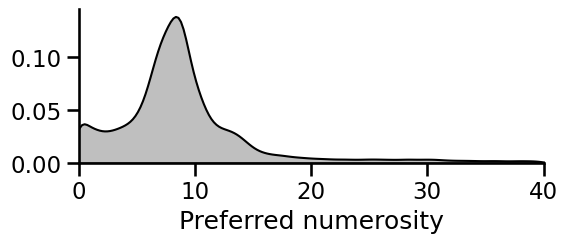

In [58]:
tmp = pars.stack('session')

tmp = tmp.xs('7t2', 0, 'session')

sns.kdeplot(tmp.loc[(tmp.cvr2 > 0.00) & (tmp.mu < 40), 'mu'], color='k', shade=True)
sns.despine()

plt.ylabel(None)
plt.xlabel('Preferred numerosity')
plt.xlim(0, 40)
plt.gcf().set_size_inches(6,2)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Preferred numerosity')

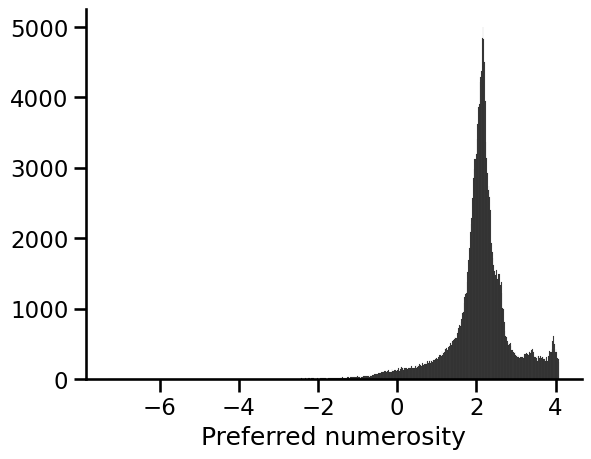

In [44]:
tmp = pars.stack('session')

tmp = tmp.xs('7t2', 0, 'session')

tmp['log(mu)'] = np.log(tmp['mu'])
sns.histplot(tmp.loc[(tmp.cvr2 > 0.0) & (tmp.mu < 60), 'log(mu)'], color='k')
sns.despine()

plt.ylabel(None)
plt.xlabel('Preferred numerosity')
# plt.xlim(0, 60)

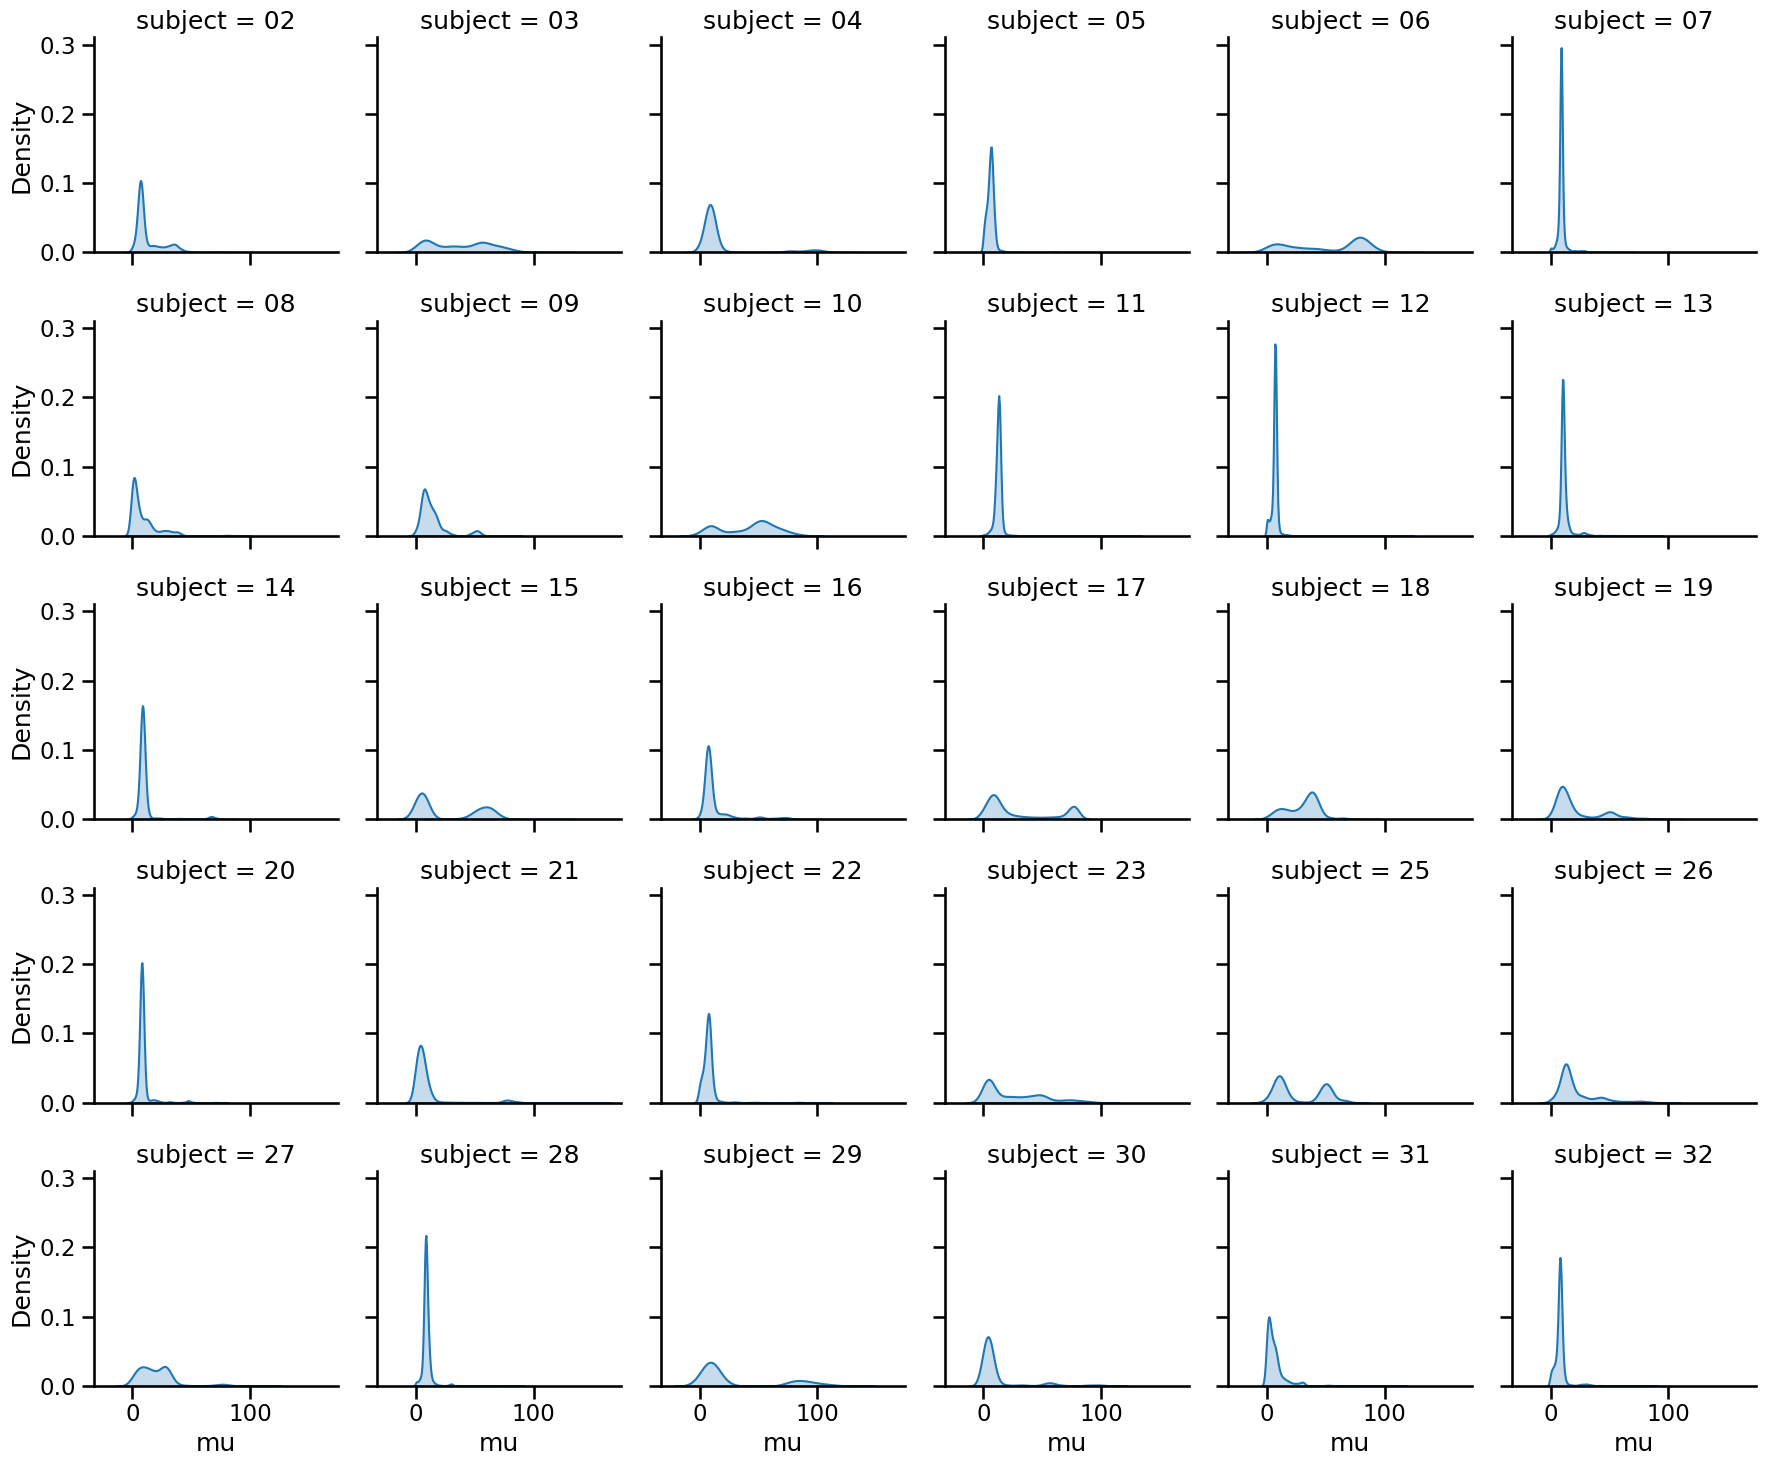

In [51]:


fac = sns.FacetGrid(tmp[tmp.cvr2 > 0.0].reset_index(), col='subject', col_wrap=6)
fac.map(sns.kdeplot, 'mu', fill=True)

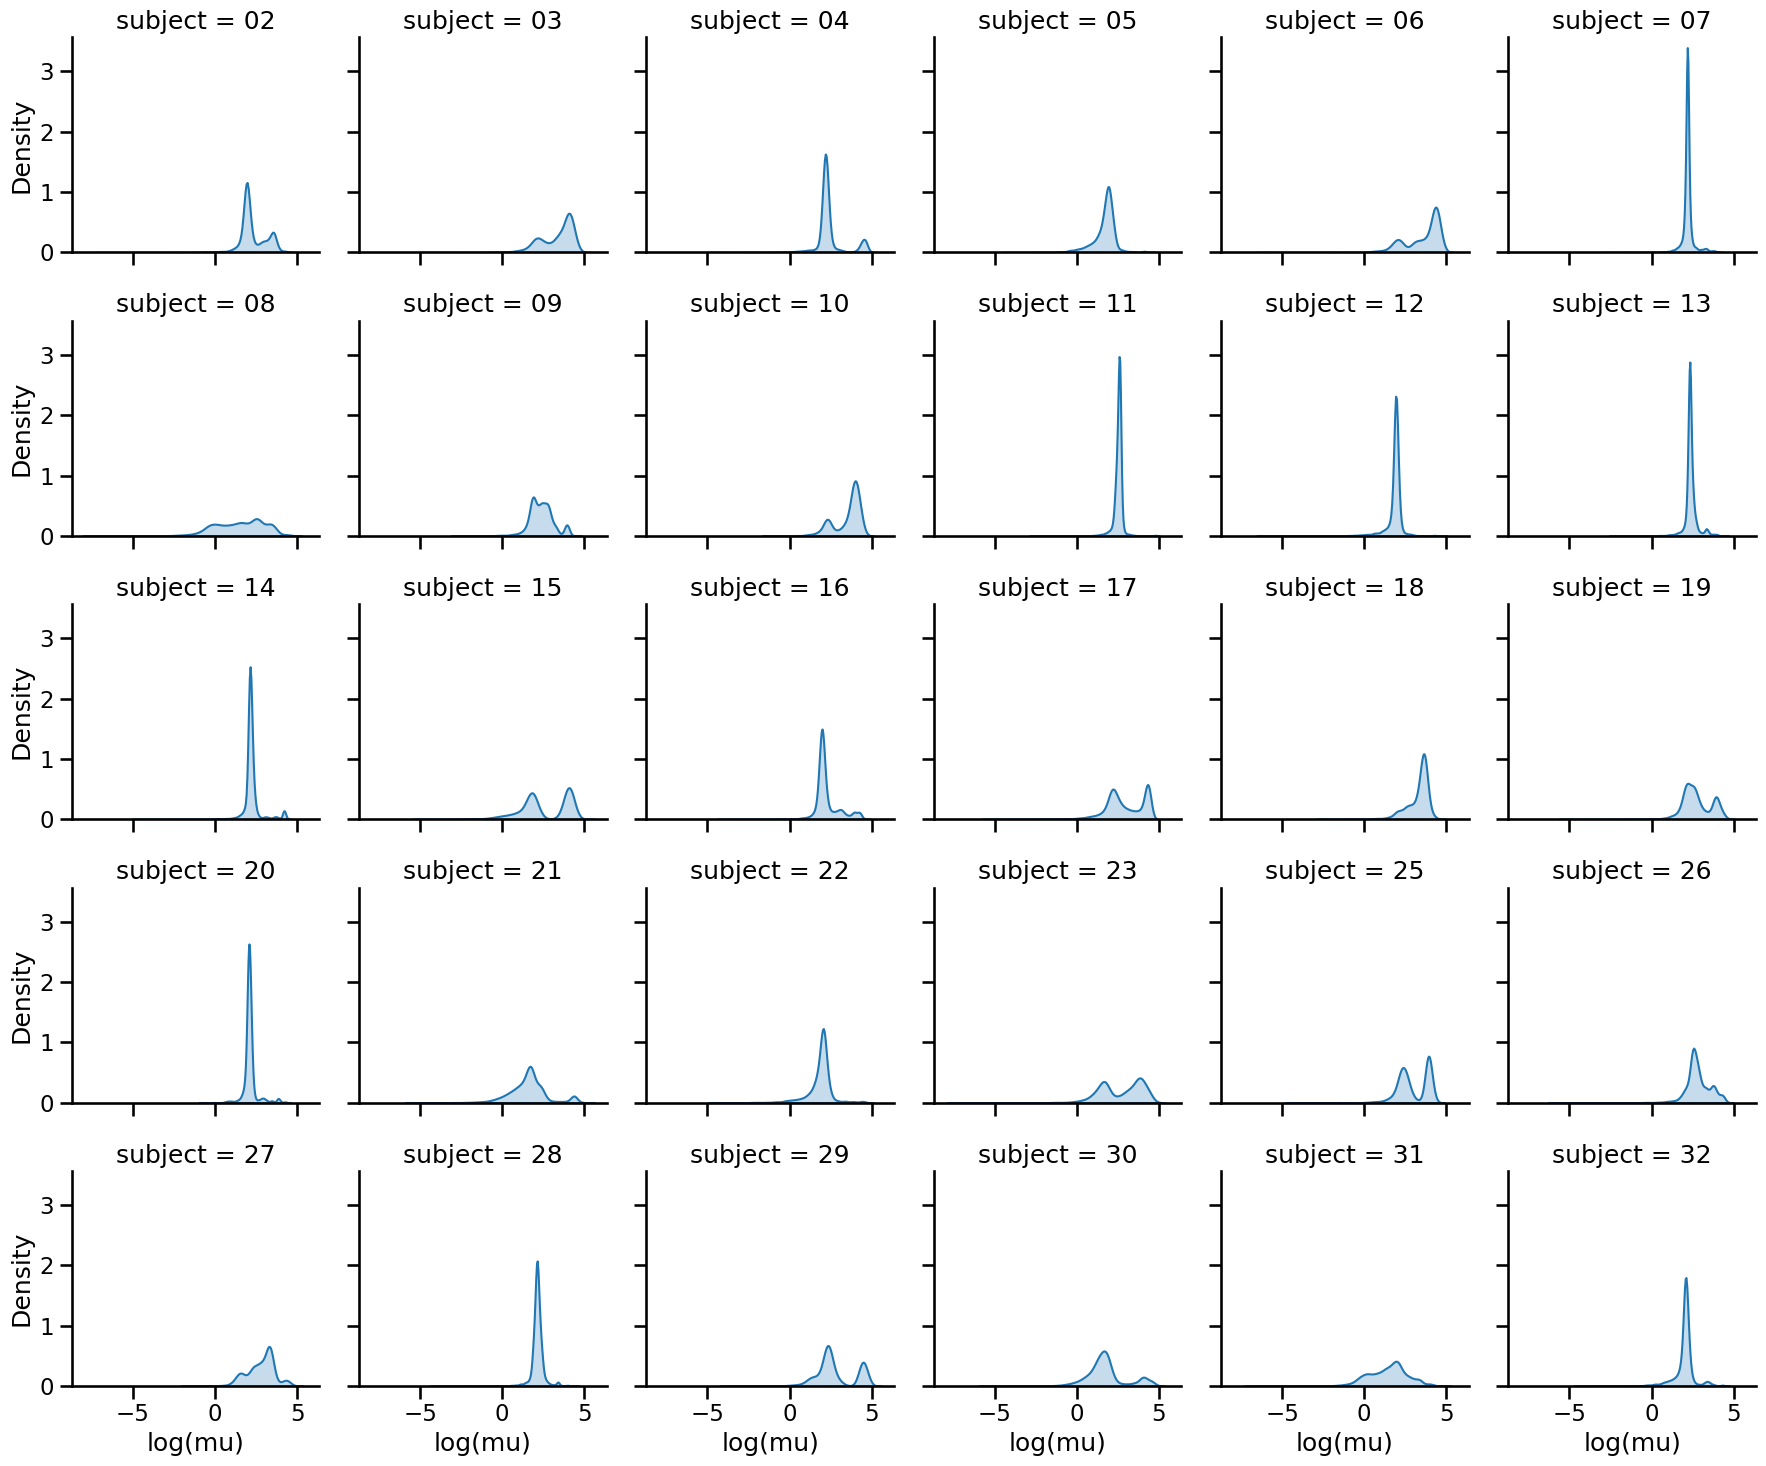

In [53]:


fac = sns.FacetGrid(tmp[tmp.cvr2 > 0.0].reset_index(), col='subject', col_wrap=6)
fac.map(sns.kdeplot, 'log(mu)', fill=True)

In [ ]:
fac = sns.FacetGrid(tmp[tmp.cvr2 > 0.0].reset_index(), col='subject', col_wrap=6)
fac.map(sns.regplot, 'mu', 'std' shade=True)